+  朴素贝叶斯假设特征之间是条件独立的，**所以对相关性较高的数据表现不好**，分类效力不强，也不可以和PCA和SVD一起用
+  朴素贝叶斯是一个**不建模**的算法，有点像KMeans，lazy learning，不需要参数
+ 对于连续性变量，就没有办法通过单纯的占比来计算概率了，使用分布进行概率预测

垃圾邮件过滤，文本分类，贝叶斯分布所需样本量比较少，运行比SVM和随机森林快

In [1]:
from sklearn.naive_bayes import GaussianNB #正态分布，即假设所有p(x|y)服从正态分布，目标是最大化p(x|y)，求出此时高斯分布的参数
from sklearn.naive_bayes import BernoulliNB #伯努利分布
from sklearn.naive_bayes import MultinomialNB #多项式分布

In [ ]:
GaussianNB()

GaussianNB参数
+ prior：表示类的先验概率,不指定则自行根据数据计算先验概率p（y）,不用填让他自己算
+ var_smoothing 也用不上

用法也很普通,接口也是通常的fit,score,predict,predict_proba

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve #画学习曲线的类
from sklearn.model_selection import ShuffleSplit #设定交叉验证模式的类
from time import time
import datetime

In [ ]:
def plot_learning_curve(estimator,title, X, y, 
                        ax, #选择子图
                        ylim=None, #设置纵坐标的取值范围
                        cv=None, #交叉验证
                        n_jobs=None #设定要使用的线程
                       ):
    
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y
                                                            ,cv=50,n_jobs=n_jobs)    
#首先，找出每个图像所需要的横纵坐标 - learning_curve，这里的学习曲线的变量是训练集的不同大小
#estimator分类器，cv是交叉验证,n_jobs:运行使用多少运算资源，-1表示全部使用，可能会很卡
# train_size 数组：长度是训练模型的次数，每次训练所用的训练集递增 ，这里为5说明建模了5次
#train_scores shape(5,50)，5次建模，50次交叉验证分数
    ax.set_title(title) #设置标题
    if ylim is not None:
        ax.set_ylim(*ylim)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.grid() #显示网格作为背景，不是必须
    ax.plot(train_sizes, np.mean(train_scores, axis=1), 'o-'
            , color="r",label="Training score")
    ax.plot(train_sizes, np.mean(test_scores, axis=1), 'o-'
            , color="g",label="Test score")
    ax.legend(loc="best")
    return ax

In [2]:
digits = load_digits()
X, y = digits.data, digits.target

In [4]:
gs=GaussianNB().fit(X,y)

In [25]:
X.shape

(1797, 64)

In [26]:
X #是一个稀疏矩阵

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [27]:
title = ["Naive Bayes","DecisionTree","SVM, RBF kernel","RandomForest","Logistic"]
model = [GaussianNB(),DTC(),SVC(gamma=0.001)
         ,RFC(n_estimators=50),LR(C=.1,solver="lbfgs")]
cv = ShuffleSplit(n_splits=50, test_size=0.2, random_state=0)

Naive Bayes:00:05:958065
DecisionTree:00:01:715406
SVM, RBF kernel:00:11:917125
RandomForest:00:14:878207
Logistic:00:37:884670


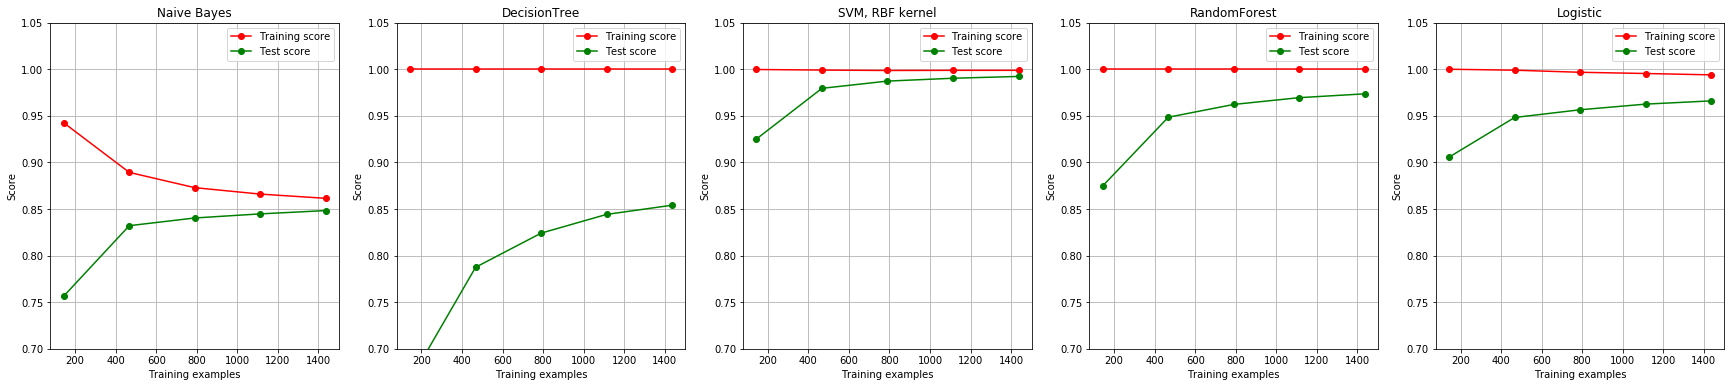

In [28]:
fig, axes = plt.subplots(1,5,figsize=(30,6))
for ind, title_, estimator in zip(range(len(title)),title,model):
    times = time()
    plot_learning_curve(estimator, title_, X, y,
                        ax=axes[ind], ylim = [0.7, 1.05],n_jobs=4, cv=cv)
    print("{}:{}".format(title_,datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f")))
plt.show()

In [29]:
[*zip(range(len(title)),title,model)]

[(0, 'Naive Bayes', GaussianNB(priors=None, var_smoothing=1e-09)),
 (1,
  'DecisionTree',
  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, presort=False, random_state=None,
              splitter='best')),
 (2,
  'SVM, RBF kernel',
  SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)),
 (3,
  'RandomForest',
  RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
              max_depth=None, max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_s

### 概率分类器的评价指标

In [37]:
from sklearn.metrics import brier_score_loss  # 公式就像均方误差

In [39]:
#在二分类情况下，接口predict_proba会返回两列，预测为0和预测为1的概率 但SVC的接口decision_function却只会返回一列
#要随时注意，使用了怎样的概率分类器，以辨别查找置信度的接口，以及这些接口的结构
brier_score_loss(Ytest, prob[:,1], pos_label=1)  
#注意，第一个参数是真实标签，第二个参数是预测出的概率值
#表示的是去到概率预测中，正样本等于1的概率
#即这里测算的是，对于样本分类为1时的可靠程度

0.032619662406118764

In [55]:
from sklearn.metrics import log_loss   # 常用指标，用于多个模型比较
                                        # 会偏向于有最优化函数的算法（如逻辑回归和SVC）
    #布利尔衡量单一模型表现，可解释性更强

In [56]:
log_loss(Ytest,prob)

2.4725653911460683

In [57]:
log_loss(Ytest,logi.predict_proba(Xtest))

0.1275229757665521

In [58]:
log_loss(Ytest,svc_prob)

1.625556312147472

#### 可靠性曲线
预测概率为横坐标，真是标签为纵坐标，越靠近对角线越好

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification as mc
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split

In [60]:
X, y = mc(n_samples=100000,n_features=20 #总共20个特征
          ,n_classes=2 #标签为2分类
          ,n_informative=2 #其中两个代表较多信息
          ,n_redundant=10 #10个都是冗余特征
          ,random_state=42)

In [61]:
X.shape

(100000, 20)

In [62]:
np.unique(y)

array([0, 1])

In [63]:
#样本量足够大，因此使用1%的样本作为训练集
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y
                                                ,test_size=0.99 #训练集会很小，测试集会很大
                                                ,random_state=42)

In [67]:
gnb = GaussianNB()
gnb.fit(Xtrain,Ytrain)
y_pred = gnb.predict(Xtest)
prob_pos = gnb.predict_proba(Xtest)[:,1] #我们的预测概率 - 横坐标
clf_score = gnb.score(Xtest,Ytest)
#Ytest - 我们的真实概率- 纵坐标
#但是，真实概率是不可获得的，可以计算类概率，如将频率当作概率

In [75]:
from sklearn.calibration import calibration_curve

In [76]:
#从类calibiration_curve中获取横坐标和纵坐标
trueproba, predproba = calibration_curve(Ytest, prob_pos #真实标签，预测返回的概率
                                         ,n_bins=10 #输入希望分箱的个数
                                        )
#predproba每个箱子概率的均值

In [77]:
trueproba.shape

(10,)

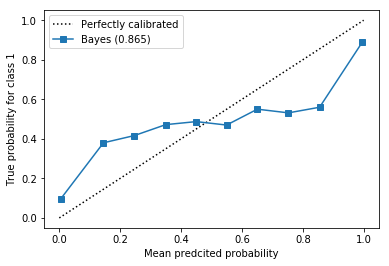

In [78]:
fig = plt.figure()
ax1 = plt.subplot()
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
ax1.plot(predproba, trueproba,"s-",label="%s (%1.3f)" % ("Bayes", clf_score))
ax1.set_ylabel("True probability for class 1")
ax1.set_xlabel("Mean predcited probability")
ax1.set_ylim([-0.05, 1.05])
ax1.legend()
plt.show()

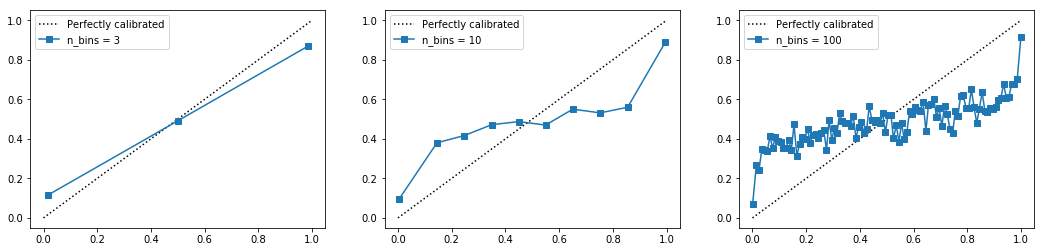

In [79]:
fig, axes = plt.subplots(1,3,figsize=(18,4))
for ind,i in enumerate([3,10,100]):
    ax = axes[ind]
    ax.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    trueproba, predproba = calibration_curve(Ytest, prob_pos,n_bins=i)
    ax.plot(predproba, trueproba,"s-",label="n_bins = {}".format(i))
    ax1.set_ylabel("True probability for class 1")
    ax1.set_xlabel("Mean predcited probability")
    ax1.set_ylim([-0.05, 1.05])
    ax.legend()
plt.show()

In [80]:
name = ["GaussianBayes","Logistic","SVC"]

gnb = GaussianNB()
logi = LR(C=1., solver='lbfgs',max_iter=3000,multi_class="auto")
svc = SVC(kernel = "linear",gamma=1) #置信度

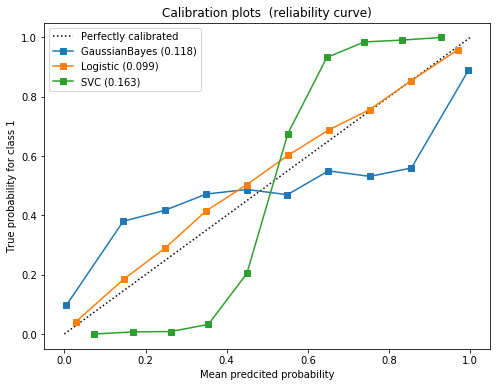

In [81]:
fig, ax1 = plt.subplots(figsize=(8,6))
ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

for clf, name_ in zip([gnb,logi,svc],name):
    clf.fit(Xtrain,Ytrain)
    y_pred = clf.predict(Xtest)
    #hasattr(obj,name)：查看一个类obj中是否存在名字为name的接口，存在则返回True
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(Xtest)[:,1]
    else:  # use decision function
        prob_pos = clf.decision_function(Xtest)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    #返回布里尔分数
    clf_score = brier_score_loss(Ytest, prob_pos, pos_label=y.max())
    trueproba, predproba = calibration_curve(Ytest, prob_pos,n_bins=10)
    ax1.plot(predproba, trueproba,"s-",label="%s (%1.3f)" % (name_, clf_score))
    
ax1.set_ylabel("True probability for class 1")
ax1.set_xlabel("Mean predcited probability")
ax1.set_ylim([-0.05, 1.05])
ax1.legend()
ax1.set_title('Calibration plots  (reliability curve)')
plt.show()

### 概率校准
提高概率预测的可靠性

In [83]:
def plot_calib(models,name,Xtrain,Xtest,Ytrain,Ytest,n_bins=10):
    
    import matplotlib.pyplot as plt
    from sklearn.metrics import brier_score_loss
    from sklearn.calibration import calibration_curve
    
    fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,6))
    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    for clf, name_ in zip(models,name):
        clf.fit(Xtrain,Ytrain)
        y_pred = clf.predict(Xtest)
        #hasattr(obj,name)：查看一个类obj中是否存在名字为name的接口，存在则返回True
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(Xtest)[:,1]
        else:  # use decision function
            prob_pos = clf.decision_function(Xtest)
            prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
        #返回布里尔分数
        clf_score = brier_score_loss(Ytest, prob_pos, pos_label=y.max())
        trueproba, predproba = calibration_curve(Ytest, prob_pos,n_bins=n_bins)
        ax1.plot(predproba, trueproba,"s-",label="%s (%1.3f)" % (name_, clf_score))
        ax2.hist(prob_pos, range=(0, 1), bins=n_bins, label=name_,histtype="step",lw=2)
    
    ax2.set_ylabel("Distribution of probability")
    ax2.set_xlabel("Mean predicted probability")
    ax2.set_xlim([-0.05, 1.05])
    ax2.legend(loc=9)
    ax2.set_title("Distribution of probablity")
    ax1.set_ylabel("True probability for class 1")
    ax1.set_xlabel("Mean predcited probability")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend()
    ax1.set_title('Calibration plots(reliability curve)')
    plt.show()

In [84]:
from sklearn.calibration import CalibratedClassifierCV

In [85]:
name = ["GaussianBayes","Logistic","Bayes+isotonic","Bayes+sigmoid"]

gnb = GaussianNB()

models = [gnb
          ,LR(C=1., solver='lbfgs',max_iter=3000,multi_class="auto")
        #定义两种校准方式
          ,CalibratedClassifierCV(gnb, cv=2, method='isotonic')
          ,CalibratedClassifierCV(gnb, cv=2, method='sigmoid')]

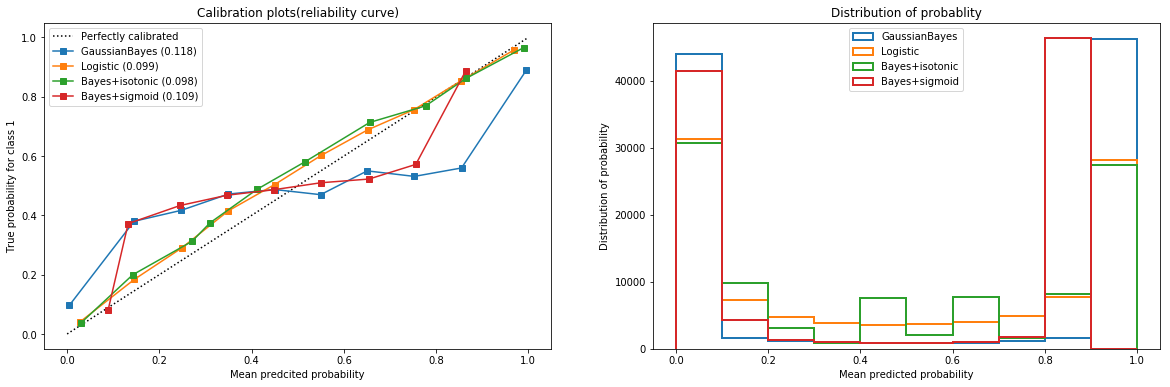

In [86]:
plot_calib(models,name,Xtrain,Xtest,Ytrain,Ytest)

In [87]:
gnb = GaussianNB().fit(Xtrain,Ytrain)
gnb.score(Xtest,Ytest)

0.8650606060606061

In [88]:
brier_score_loss(Ytest,gnb.predict_proba(Xtest)[:,1],pos_label = 1)

0.11760826355000835

In [89]:
gnbisotonic = CalibratedClassifierCV(gnb, cv=2, method='isotonic').fit(Xtrain,Ytrain)
gnbisotonic.score(Xtest,Ytest)

0.8626767676767677

In [90]:
brier_score_loss(Ytest,gnbisotonic.predict_proba(Xtest)[:,1],pos_label = 1)

0.09833190251353853

精确度降低，但可靠性提升了，是否使用还是取决于自己判断

In [93]:
#测试下对于SVC的校准
name_svc = ["SVC","SVC+isotonic","SVC+sigmoid"]

svc = SVC(kernel = "linear",gamma=1)

models_svc = [svc
              ,CalibratedClassifierCV(svc, cv=2, method='isotonic')
              ,CalibratedClassifierCV(svc, cv=2, method='sigmoid')]

for clf, name in zip(models_svc,name_svc):
    clf.fit(Xtrain,Ytrain)
    y_pred = clf.predict(Xtest)
    if hasattr(clf, "predict_proba"):
        prob_pos = clf.predict_proba(Xtest)[:, 1]
    else:
        prob_pos = clf.decision_function(Xtest)
        prob_pos = (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())
    clf_score = brier_score_loss(Ytest, prob_pos, pos_label=y.max())
    score = clf.score(Xtest,Ytest)
    print("{}:".format(name))
    print("\tBrier:{:.4f}".format(clf_score))
    print("\tAccuracy:{:.4f}".format(score))

SVC:
	Brier:0.1630
	Accuracy:0.8633
SVC+isotonic:
	Brier:0.0999
	Accuracy:0.8639
SVC+sigmoid:
	Brier:0.0987
	Accuracy:0.8634


### 多项式贝叶斯

In [95]:
from sklearn.preprocessing import MinMaxScaler  # 归一化到0-1之间
from sklearn.naive_bayes import MultinomialNB

+ 多项式实验，每次实验都可能有不同的结果，在任何给定的实验中，特定结果发生的概率是不变的，如投掷硬币
+ 多项式模型擅长离散型变量，且特征互相独立，不接受负值输入，常用于文本分类
+ 参数
alpha：取值0-1，平滑系数，默认为1，越大则噪音越大
通常参数都不要调整
+ 属性：
查看每个类别真正的概率值
np.exp(mnb.class_log_prior_)

## 伯努利贝叶斯
+ 表示服从二项分布的模型，每个特征都是二分类（0,1），跟多项式贝叶斯相似
+ 如果相对连续性变量使用，首先进行归一化，然后以0.5为门槛分为两类即可
+ BernoulliNB(binarize=0.5)#表示设置阈值为0.5

以上3种贝叶斯模型无法处理样本不平衡问题，recall分数会很低
故需要用
### 补集朴素贝叶斯

In [158]:
from sklearn.naive_bayes import ComplementNB
from time import time
import datetime

name = ["Multinomial","Gaussian","Bernoulli","Complement"]
models = [MultinomialNB(),GaussianNB(),BernoulliNB(),ComplementNB()]

for name,clf in zip(name,models):
    times = time()
    Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,y
                                                ,test_size=0.3
                                                ,random_state=420)
    #预处理
    if name != "Gaussian":
        kbs = KBinsDiscretizer(n_bins=10, encode='onehot').fit(Xtrain)
        Xtrain = kbs.transform(Xtrain)
        Xtest = kbs.transform(Xtest)
    
    clf.fit(Xtrain,Ytrain)
    y_pred = clf.predict(Xtest)
    proba = clf.predict_proba(Xtest)[:,1]
    score = clf.score(Xtest,Ytest)
    print(name)
    print("\tBrier:{:.3f}".format(BS(Ytest,proba,pos_label=1)))
    print("\tAccuracy:{:.3f}".format(score))
    print("\tRecall:{:.3f}".format(recall_score(Ytest,y_pred)))
    print("\tAUC:{:.3f}".format(AUC(Ytest,proba)))
    print(datetime.datetime.fromtimestamp(time()-times).strftime("%M:%S:%f"))

Multinomial
	Brier:0.007
	Accuracy:0.990
	Recall:0.000
	AUC:0.991
00:00:050863
Gaussian
	Brier:0.006
	Accuracy:0.990
	Recall:0.438
	AUC:0.993
00:00:038898
Bernoulli
	Brier:0.009
	Accuracy:0.987
	Recall:0.771
	AUC:0.987
00:00:049866
Complement
	Brier:0.038
	Accuracy:0.953
	Recall:0.987
	AUC:0.991
00:00:044881
